#### Lorenzo Ausilio
#### Advanced Statistics 4 Physics Analysis
#### 28 September 2022

# _Bayesian Blocks : An algorithm for histogram representation_

## 1. Introduction

The algorithm was firstly introduced for detecting localized spikes that characterize intensity variations in astronomical data. The input is raw counting data, such as binned counts, and the output is the most probable segmentation of the observation into time intervals where the amplitude has no stastically significant variations, i.e. where it is constant. The main idea behind Bayesian Blocks is to __represent the data__ in a discontinous, piecewise constant form __in order to have an approximate model that is__ often __useful__ for a deeper understanding, or in other words to design a histogram that is able to distinguish between observational errors and statistical significance. The name of the algorithm stems from fact that Bayesian statistics is used for analysis. 

## 2. Bayesian Blocks

### 2.1 Piecewise constant model

The independent variables,e.g. time, are divided into smaller intervals called blocks, which in this bayesian approach are usually unequal in size one from another, whereas the dependent variables, e.g. the intensity, are modelled as constant in a single block. <br> <br>
Change points are defined as the points that end one block and start the next. Having defined this, we can now mention the following useful parameters:
- $N_{cp}$, the number of change-points.

- $t_k^{cp}$, the change-point which starts block $k$

- $X_k$, the signal amplitude in block $k$ <br>
for $k = 1,2,...,N_{blocks}$

### 2.2 Fitness 

The number of blocks and their edges are found through optimization of what is called a __fitness function__.
The fitness function is block-additive, meaning that $$F_{total} = \sum_{k=1}^{N_{blocks}} f(B_k)$$
where $F_{total}$ is the total fitness of one partition and $f(B_k)$ is the fitness of block k, i.e. __a measure of how well a constant signal represents the data within a block__.<br>
Thus : the blocks can be treated independently, i.e. the fitness of block k does not depend on the fitness of any other block. <br> <br>
$\rightarrow$ __The best model is found by maximizing $F_{total}$ over all possible partitions__.

The fitness function we use is the __cash function__ and is given by: <br>  $$ log L_{max} ^{(k)} + N^{(k)} = N^{(k)} ( \log N^{(k)} - \log T^{(k)} )$$

### 2.3 Priors for the number of blocks

- __Uniform prior:__ uniform prior on the number of blocks between $0$ and $N$
- __Geometric prior:__ given by $$P(N_{blocks}) = P_0 \gamma^{N_{blocks}}$$ where $P_0$ is the normalization constant defined as:
$$
P_0 = \frac{1-\gamma}{1-\gamma^{N+1}}
$$
    - $\gamma < 1$ expresses the fact that a smaller number of blocks is more likely than a bigger number <br><br>
- __Calibrated Prior for Event Data:__ defined as $$log P(N,p_0) = 4 - \log(73.53 p_0 N^{-0.478}) $$

### 2.4 Algorithm

The function:
```R
bayesian_blocks <- function(data,data_type='array',prior='p0',gamma=0.01,p0=0.01)
```

where :
- __data__ : the data to be partitioned in blocks
- __data type__ : a string, it can be either "array" to signify a list of data or "histogram" for a histogram of data
- __prior__ : a string, can either be "uniform" for a uniform prior, "gamma" for a gamma prior, or "p0" for a calibrated prior
- __gamma__ : a float, parameter characterizing the slope of the prior for the number of blocks
- __p0__ : a float, correct detection rate parameter

In [18]:
bayesian_blocks <- function(data,data_type='array',prior='p0',gamma=0.01,p0=0.01){
    

    # if data is an array of float
    if(data_type=='array'){
            # load require library for function count func
            require(plyr)
            # take care of repeated data
            x_sorted <- sort(data)
            x_unique <- unique(x_sorted) 
            x_weight <- count(x_sorted)$freq
    }
    else if(data_type=='hist'){
            br       <- data$breaks
            x_unique <- c(br[1],data$mids,br[length(br)])
            x_weight <- c(1,data$counts,1)
    }
    else{
            stop('Error: data type must be an array')
    }
    
    # copy vector 
    x <- x_unique
    N <- length(x)

    # create vector of cell edges
    edges <- c(x[1], 0.5 * (x[2:N] + x[1:(N-1)]), x[N])
    
    # create matrix needed for the iteration
    best   <- matrix(0,nrow=1,ncol=N)
    last   <- matrix(0,nrow=1,ncol=N)    
    
    # the fitness function
    log_fitness <- function(N_k,T_k,string){
                  return( N_k * ( log(N_k) - log(T_k) ) )
                  }
 
    # pre-defined (log)prior distributions on the number of changepoints
    log_prior <- function(string){     
              if(string=='uniform'){
                  return( 0 )
              }
              else if(string=='gamma'){
                  return( -log(gamma) )
              }
              else if(string=='p0'){
                  return( 4 - log(73.53 * p0 * N**(-0.478)) )
              }
              else{
                  stop("Error: no available prior selected.")
              }
    }
    
    # prior on the number of blocks (cp), i.e. either uniform, gamma or calibrated prior
    ncp_prior <-  log_prior(string=prior)
    
    # Start with first data cell; add one cell at each iteration
        
    for(K in 1:N){
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width <- edges[K+1]-edges[1:K] 
        count_vec <- rev( cumsum(x_weight[1:K]) )   
        
        # evaluate fitness function for these possibilities
        fit_vec <- log_fitness(N_k=count_vec,T_k=width,string=string_f) 
        fit_vec <- fit_vec - ncp_prior     
        fit_vec[2:K] <- fit_vec[2:K] + best[1:(K-1)]

        # find the max of the fitness, i.e. the K^th changepoint
        i_max   <- which.max(fit_vec)
        
        # save best configuration
        last[K] <- i_max
        best[K] <- fit_vec[i_max]      
        }
    
# iteratively peel of the last block to retrieve the change points
    change_points <- matrix(0,nrow=1,ncol=N)
    i_cp          <- N + 1
    ind           <- N + 1
    
    while(TRUE){
        i_cp <- i_cp - 1 
        change_points[i_cp] <- ind 
        
        if(ind==1){
            break 
            }
        ind <- last[ind-1]        
    }
    
    change_points <- change_points[(i_cp):N]    
    return(edges[change_points])
}

### 3. Application : Histogram representation

#### 3.1 Dummy dataset : uniform noise and gaussian signal

In [25]:
library(latex2exp)

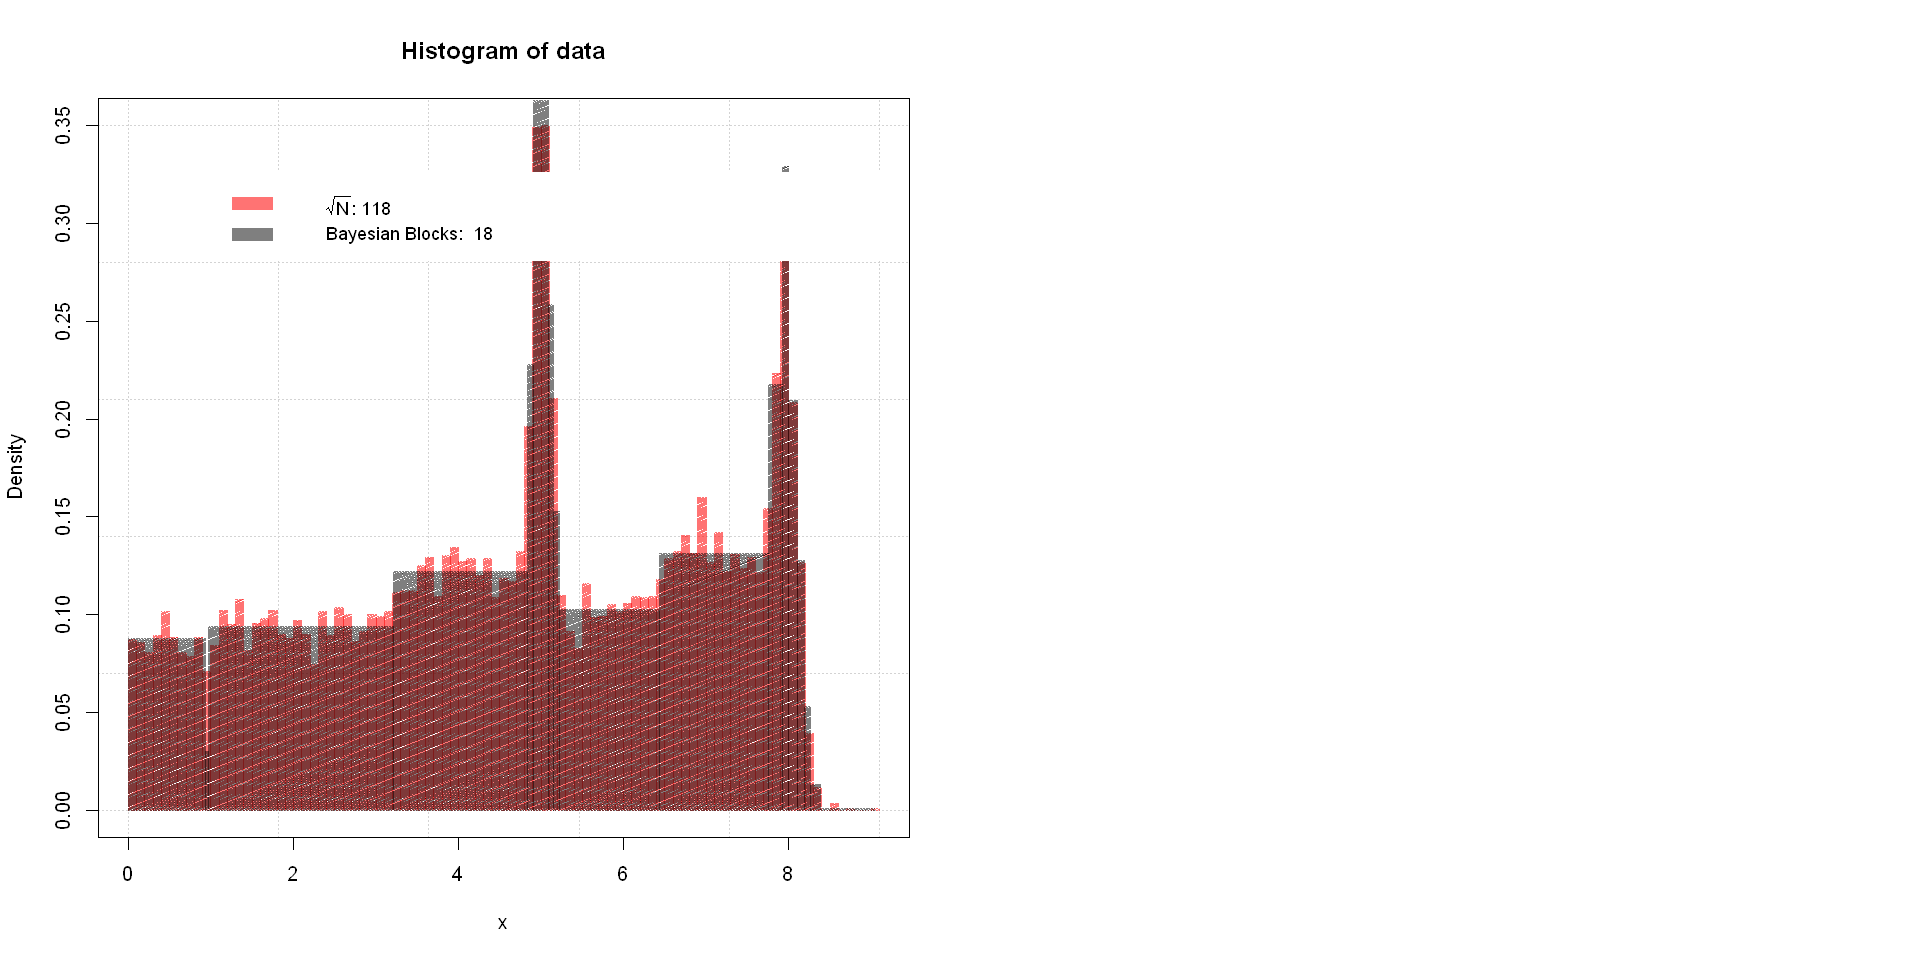

In [24]:
set.seed(40)
noise <- runif(1e4,0,8)
data1 <- rnorm(1e3,4,0.7)
data2 <- rnorm(1e3,7,0.6)
data3 <- rnorm(1e3,5,0.1)
data4 <- rnorm(1e3,8,0.13)

tot_sig <- c(noise,data1,data2,data3,data4)

data <- tot_sig
N    <- length(data)

#plot
par(mfrow=c(1,2))
options(repr.plot.width=16, repr.plot.height=8)

# breaks = sqrt(N)
hist(data,breaks=sqrt(N),freq=FALSE,col=scales::alpha('red',.55),border=F, panel.first=grid(),density=200,
     xlab='x',ylab='Density')

# breaks = Bayesian Blocks
breaks = bayesian_blocks(data,prior='gamma',gamma=0.01)
hist(data,breaks=breaks,density=200,
     freq=FALSE,col=scales::alpha('black',.5),border=F,add=T)

legend("topleft", inset=0.1,legend=c(TeX(sprintf("$\\sqrt{ N }$: %3i",floor(sqrt(N)))),sprintf("Bayesian Blocks: %3i",length(breaks))),
       fill=c(scales::alpha('red',.55),scales::alpha('black',.5)),cex=0.9,box.lty=0, border=F)
box()

#### 3.2 Energy spectrum dataset (HPGe detector and Eu152 source)

Length dataset: 702247

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"1 y value <= 0 omitted from logarithmic plot"


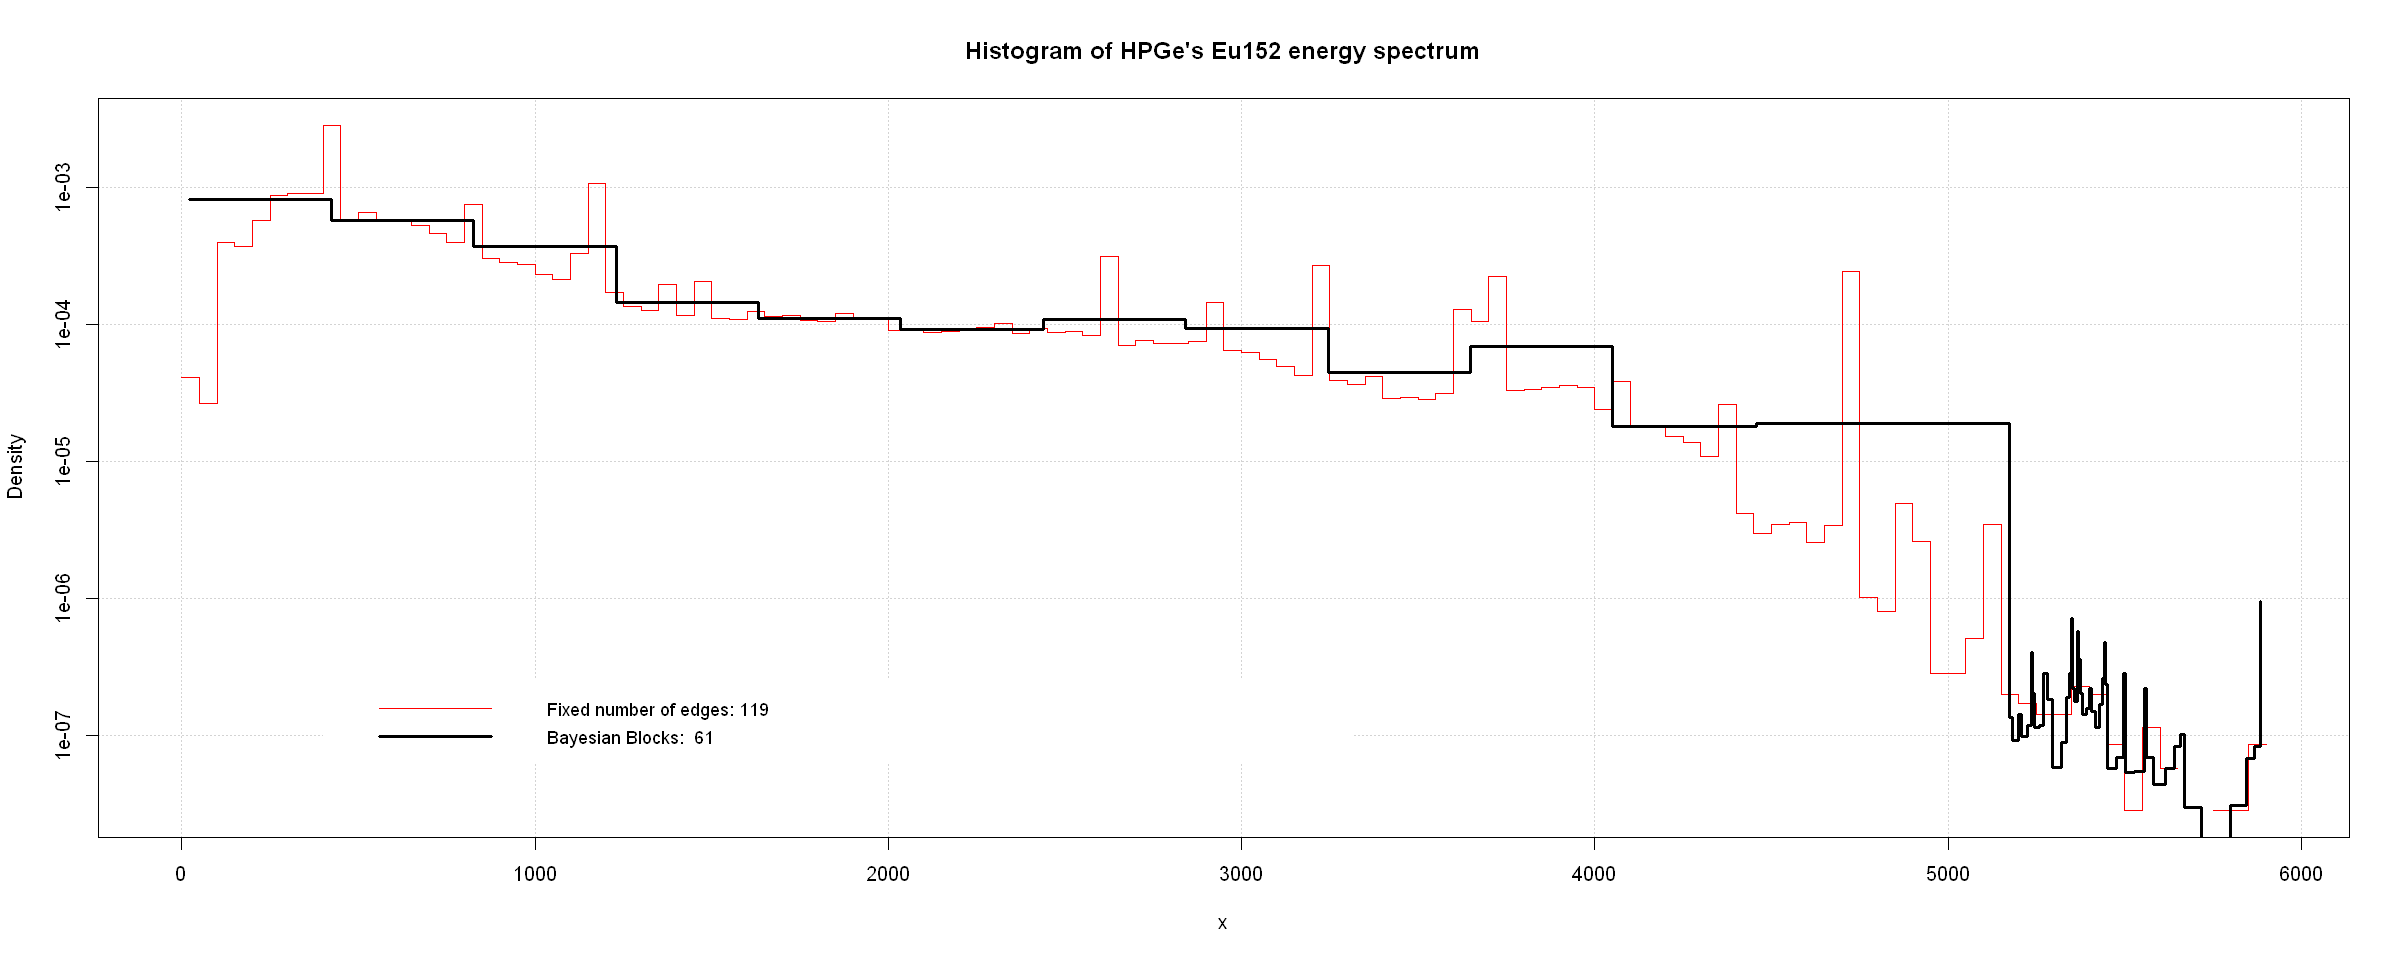

In [36]:
# data 
filename <- "energySpec_dataset.txt"
data  <- read.table(filename, header=FALSE, sep='\n',skip=2, col.names='y') 
dim <- dim(data)[1]
cat('Length dataset:', dim)

h1 <- hist(data$y,breaks=200,plot=F)
h2 <- hist(data$y,breaks=bayesian_blocks(data$y,data_type='array',prior='gamma',gamma=0.1),plot=F)

# Plot histogram of generated random numbers 
par(mfrow=c(1,1))
options(repr.plot.width=20, repr.plot.height=8)

# Plot with fixed breaks
plot(x=h1$breaks[1:length(h1$breaks)], y=c(h1$density,tail(h1$density,n=1)), log='y',panel.first=grid(),
     col='red',lwd=1.5, type='s', xlab='x',ylab='Density',
     main="Histogram of HPGe's Eu152 energy spectrum")
# Bayesian Blocks
lines(x=h2$breaks[1:length(h2$breaks)], y=c(h2$density,tail(h2$density,n=1)), type='s', lwd=3,col='black')

legend("bottomleft", inset=+0.1,legend=c(sprintf("Fixed number of edges: %3i",length(h1$breaks)),sprintf("Bayesian Blocks: %3i",length(h2$breaks))),
       col=c("red","black"),lty=c(1,1), lwd=c(1.5,3), cex=0.9,box.lty=0, border=F)